In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import lightning as L
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [3]:
o_image = [
    [0, 0, 1, 1, 0, 0],
    [0, 1, 0, 0, 1, 0],
    [1, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 1],
    [0, 1, 0, 0, 1, 0],
    [0, 0, 1, 1, 0, 0]
]

x_image = [
    [1, 0, 0, 0, 0, 1],
    [0, 1, 0, 0, 1, 0],
    [0, 0, 1, 1, 0, 0],
    [0, 0, 1, 1, 0, 0],
    [0, 1, 0, 0, 1, 0],
    [1, 0, 0, 0, 0, 1]
]

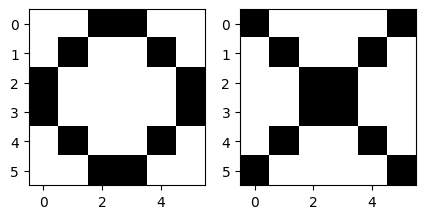

In [6]:
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))
axarr[0].imshow(o_image, cmap='gray_r')
axarr[1].imshow(x_image, cmap='gray_r')
plt.show()

In [10]:
#converting the images to tensors
input_images = torch.tensor([o_image, x_image], dtype=torch.float32)

In [11]:
#creating the labels
input_labels = torch.tensor([[1.0, 0.0], [0.0, 1.0]], dtype=torch.float32)

In [12]:
dataset = TensorDataset(input_images, input_labels)
dataloader = DataLoader(dataset)

In [13]:
for batch_num, (images, labels) in enumerate(dataloader):
    print(f'Batch number: {batch_num}')
    print(f'Images: {images}')
    print(f'Labels: {labels}')
    print()

Batch number: 0
Images: tensor([[[0., 0., 1., 1., 0., 0.],
         [0., 1., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 1.],
         [0., 1., 0., 0., 1., 0.],
         [0., 0., 1., 1., 0., 0.]]])
Labels: tensor([[1., 0.]])

Batch number: 1
Images: tensor([[[1., 0., 0., 0., 0., 1.],
         [0., 1., 0., 0., 1., 0.],
         [0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 1., 0., 0.],
         [0., 1., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0., 1.]]])
Labels: tensor([[0., 1.]])



In [17]:
######### Defining the model #########

class SimpleCNN(L.LightningModule):
    def __init__(self):
        super().__init__()

        L.seed_everything(seed=42)

        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.input_to_hidden = nn.Linear(in_features= 4, out_features=1)

        self.hidden_to_output = nn.Linear(in_features=1, out_features=2)

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):

        x = self.conv(x)
        x = F.relu(x)
        x = self.pool(x)

        x = torch.flatten(x, 1)

        x = self.input_to_hidden(x)
        x = F.relu(x)
        x = self.hidden_to_output(x)

        return x
    
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.001)
    
    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.forward(inputs)
        loss = self.loss(outputs, labels)
        return loss

In [19]:
model = SimpleCNN()

Seed set to 42


In [20]:
trainer = L.Trainer(max_epochs=100)
trainer.fit(model, train_dataloaders=dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: d:\MachineLearningAlgorithms\SimpleCNN\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | conv             | Conv2d           | 10     | train
1 | pool             | MaxPool2d        | 0      | train
2 | input_to_hidden  | Linear           | 5      | train
3 | hidden_to_output | Linear           | 4      | train
4 | loss             | CrossEntropyLoss | 0      | train
--------------------------------------------------------------
19        Trainable params
0         Non-trainable params
19        Total params
0.000     Total estimated model params size (MB)
c:\Users\msi\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not hav

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [21]:
for batch_num, (image, label) in enumerate(dataloader):
    prediction = model(image)

    predicted_label = torch.round(
        torch.softmax(prediction, dim=1),
        decimals=2
    )

    print("predicted_label: ", predicted_label)
    print("actual_label: ", label)
    print()

predicted_label:  tensor([[0.5200, 0.4800]], grad_fn=<RoundBackward1>)
actual_label:  tensor([[1., 0.]])

predicted_label:  tensor([[0.4200, 0.5800]], grad_fn=<RoundBackward1>)
actual_label:  tensor([[0., 1.]])



In [22]:
path_to_checkpoint = trainer.checkpoint_callback.best_model_path

In [23]:
trainer = L.Trainer(max_epochs=700)
trainer.fit(model, train_dataloaders=dataloader, ckpt_path=path_to_checkpoint)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at d:\MachineLearningAlgorithms\SimpleCNN\lightning_logs\version_0\checkpoints\epoch=99-step=200.ckpt
c:\Users\msi\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:360: The dirpath has changed from 'd:\\MachineLearningAlgorithms\\SimpleCNN\\lightning_logs\\version_0\\checkpoints' to 'd:\\MachineLearningAlgorithms\\SimpleCNN\\lightning_logs\\version_1\\checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | conv             | Conv2d           | 10     | train
1 | pool             | MaxPool2d 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=700` reached.


In [24]:
for batch_num, (image, label) in enumerate(dataloader):
    prediction = model(image)

    predicted_label = torch.round(
        torch.softmax(prediction, dim=1),
        decimals=2
    )

    print("predicted_label: ", predicted_label)
    print("actual_label: ", label)
    print()

predicted_label:  tensor([[0.7900, 0.2100]], grad_fn=<RoundBackward1>)
actual_label:  tensor([[1., 0.]])

predicted_label:  tensor([[0.0100, 0.9900]], grad_fn=<RoundBackward1>)
actual_label:  tensor([[0., 1.]])



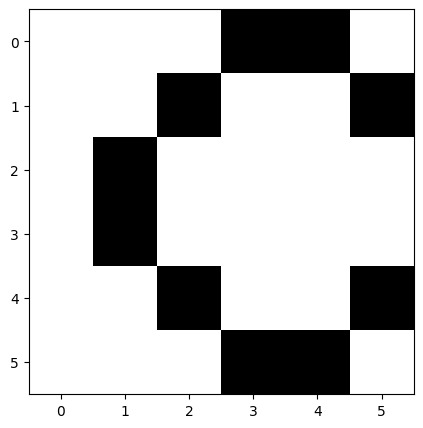

In [26]:
########### make predictions ###########
shfited_o_image = [
    [0, 0, 0, 1, 1, 0],
    [0, 0, 1, 0, 0, 1],
    [0, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1],
    [0, 0, 0, 1, 1, 0]
]

fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
axarr.imshow(shfited_o_image, cmap='gray_r')
plt.show()

In [32]:
prediction = model(torch.tensor([shfited_o_image], dtype=torch.float32))
predicted_label = torch.round(
    torch.softmax(prediction, dim=1),
    decimals=2
)

print("predicted_label: ", predicted_label)

if predicted_label[0][0] > predicted_label[0][1]:
    print("It's an O")
else:
    print("It's an X")

predicted_label:  tensor([[0.4400, 0.5600]], grad_fn=<RoundBackward1>)
It's an X


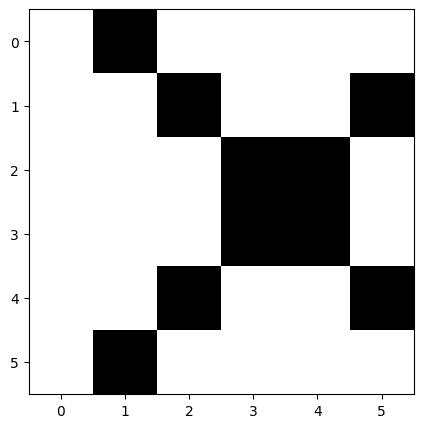

In [30]:
shfited_x_image = [
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1],
    [0, 0, 0, 1, 1, 0],
    [0, 0, 0, 1, 1, 0],
    [0, 0, 1, 0, 0, 1],
    [0, 1, 0, 0, 0, 0]
]

fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
axarr.imshow(shfited_x_image, cmap='gray_r')
plt.show()

In [33]:
prediction = model(torch.tensor([shfited_x_image], dtype=torch.float32))
predicted_label = torch.round(
    torch.softmax(prediction, dim=1),
    decimals=2
)

print("predicted_label: ", predicted_label)

if predicted_label[0][0] > predicted_label[0][1]:
    print("It's an O")
else:
    print("It's an X")

predicted_label:  tensor([[0.1200, 0.8800]], grad_fn=<RoundBackward1>)
It's an X
